<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. Автоэнкодеры


# Часть 1. Vanilla Autoencoder (10 баллов)

## 1.1. Подготовка данных (1 балл)


In [1]:
!pip install GPUtil

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch

import os
import skimage.io
import skimage
from skimage.transform import resize


from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from tqdm import tqdm_notebook
import gc
from GPUtil import showUtilization as gpu_usage


In [3]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(DEVICE)

cuda


In [5]:
!nvidia-smi

Tue Dec  5 11:21:49 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos, all_attrs

In [7]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()


Разбейте выборку картинок на train и val, выведите несколько картинок в output, чтобы посмотреть, как они выглядят, и приведите картинки к тензорам pytorch, чтобы можно было скормить их сети:

In [8]:
data_train, data_val = train_test_split(data, train_size = 0.8, shuffle=True)

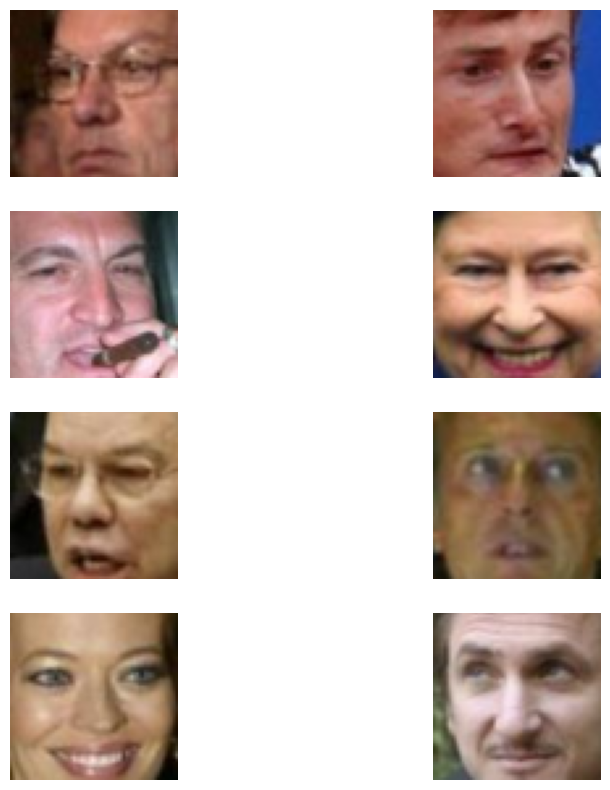

In [9]:
# выведем несколько картинок
fig, ax = plt.subplots(4, 2, figsize = (10, 10))

for i, image in enumerate(ax.flatten()):
  image.imshow(data_train[i])
  image.axis('off')

## 1.2. Архитектура модели (2 балла)
В этом разделе мы напишем и обучем обычный автоэнкодер.



<img src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F4b8adf79-8e6a-4b7d-9061-8617a00edbb1%2F__2021-04-30__14.53.33.png?table=block&id=56f187b4-279f-4208-b1ed-4bda5f91bfc0&width=2880&userId=3b1b5e32-1cfb-4b0f-8705-5a524a8f56e3&cache=v2" alt="Autoencoder">


^ напомню, что автоэнкодер выглядит вот так

In [10]:
dim_code = 256 # выберите размер латентного вектора

Реализуем autoencoder. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Экспериментируйте!

In [11]:
from copy import deepcopy

dim_features = 256  # выберите размер латентного вектора
class Autoencoder(nn.Module):
    def __init__(self):
      super().__init__()
      self.encoder = nn.Sequential(
          nn.Conv2d(3, 32, 3, padding = 1),
          nn.BatchNorm2d(32),
          nn.LeakyReLU(),

          nn.Conv2d(32, 32, 3, padding = 1),
          nn.BatchNorm2d(32),
          nn.LeakyReLU(),
          nn.MaxPool2d(kernel_size = 2, stride = 2), # 64->32

          nn.Conv2d(32, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),

          nn.Conv2d(64, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),
          nn.MaxPool2d(kernel_size = 2, stride = 2), # 32 -> 16

          nn.Conv2d(64, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),

          nn.Conv2d(64, 64, 3, padding = 1),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),
          nn.MaxPool2d(kernel_size = 2, stride = 2), # 16 -> 8

          nn.Flatten(),
          nn.Linear(8*8*64, dim_features))

      self.decoder = nn.Sequential(
          nn.Linear(dim_features, 8 * 8* 64),
          nn.Unflatten(1, (64, 8, 8)),
          nn.ConvTranspose2d(64, 64, stride = (2,2), kernel_size = 3, padding = 0),
          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.01),
          nn.ConvTranspose2d(64, 32, stride = (2,2), kernel_size = 3, padding = 1),
          nn.BatchNorm2d(32),
          nn.LeakyReLU(0.01),
          nn.ConvTranspose2d(32, 3, stride = (2,2), kernel_size = 3, padding = 2, output_padding = 1),
          nn.Sigmoid()

      )


    def forward(self, x):
        latent_code = self.encoder(x)
        reconstruction = self.decoder(latent_code)
        # <реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- латентное представление картинки (latent_code)
        # и полученная реконструкция изображения (reconstruction)>

        return reconstruction, latent_code

In [12]:
criterion = nn.BCELoss()

autoencoder = Autoencoder().to(DEVICE)

optimizer = optim.Adam(autoencoder.parameters()) #<Ваш любимый оптимизатор>
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 10, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-03.


## 1.3 Обучение (2 балла)

Осталось написать код обучения автоэнкодера. При этом было бы неплохо в процессе иногда смотреть, как автоэнкодер реконструирует изображения на данном этапе обучения. Наример, после каждой эпохи (прогона train выборки через автоэекодер) можно смотреть, какие реконструкции получились для каких-то изображений val выборки.

А, ну еще было бы неплохо выводить графики train и val лоссов в процессе тренировки =)

In [13]:
# даталоадеры
trainloader = torch.utils.data.DataLoader(torch.Tensor(data_train.swapaxes(1,3).swapaxes(2,3)), batch_size = 32, shuffle=True)
valloader = torch.utils.data.DataLoader(torch.Tensor(data_val.swapaxes(1,3).swapaxes(2,3)), batch_size = 32, shuffle=False)

In [14]:
def train(model, loss_fn, optimizer, scheduler, data_tr, data_val, n_epochs = 20):
  losses = []


  for epoch in range(n_epochs):
      model.train()
      current_epoch_loss = 0
      print('')

      for X_batch in data_tr:
        optimizer.zero_grad()

        X_batch = X_batch.to(DEVICE)
        reconstruction, latent_space = model(X_batch)
        loss = loss_fn(reconstruction, X_batch )
        loss.backward()

        optimizer.step()
        current_epoch_loss += loss.cpu().item()

      avg_loss = current_epoch_loss/len(data_tr)
      print('Epoch: {}. Loss: {}'.format(epoch+1,avg_loss))
      losses.append(avg_loss)
      scheduler.step()
  return losses

In [15]:
torch.cuda.empty_cache()
my_losses = train(autoencoder, criterion, optimizer, scheduler, data_tr=trainloader, data_val = valloader)
print(my_losses)


Epoch: 1. Loss: 0.6240734005046833
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 2. Loss: 0.6060833512468541
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 3. Loss: 0.6031403981805935
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 4. Loss: 0.6016931894340052
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 5. Loss: 0.6007363093297895
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 6. Loss: 0.6002560518795234
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 7. Loss: 0.5996685758187779
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 8. Loss: 0.5992874831051812
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 9. Loss: 0.5990322032960352
Adjusting learning rate of group 0 to 1.0000e-03.

Epoch: 10. Loss: 0.5988517314829724
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch: 11. Loss: 0.5978707412093606
Adjusting learning rate of group 0 to 1.0000e-04.

Epoch: 12. Loss: 0.5978533632849488
Adjusting learn

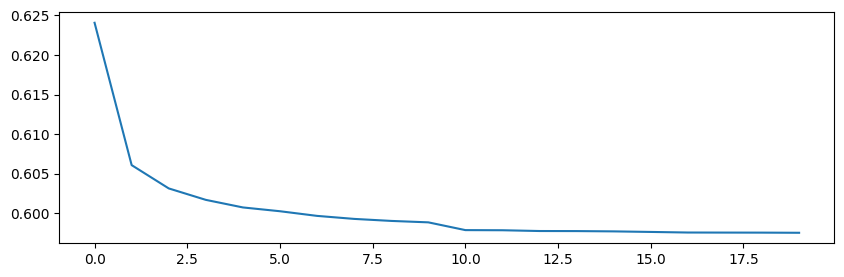

In [16]:
plt.figure(figsize=(10, 3))
plt.plot(my_losses)
plt.show()

Давайте посмотрим, как наш тренированный автоэекодер кодирует и восстанавливает картинки:

In [17]:
some_samples = next(iter(valloader))

autoencoder.eval()
with torch.no_grad():
  predictions, latent_space = autoencoder(some_samples.cuda())

In [18]:
def to_imshow(x):
  return x.permute(0, 3, 2, 1).permute(0, 2, 1, 3).cpu().detach().numpy()

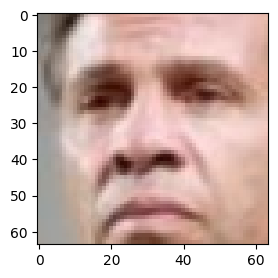

In [19]:
plt.figure(figsize=(3, 3))
plt.imshow(to_imshow(some_samples)[7])
plt.show()

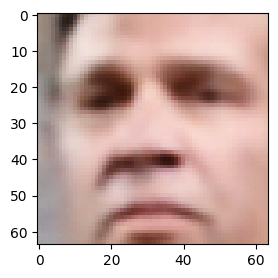

In [20]:
plt.figure(figsize=(3, 3))
plt.imshow(to_imshow(predictions)[7])
plt.show()

Not bad, right?

Oh, ee))

## 1.4. Sampling (2 балла)

Давайте теперь будем не просто брать картинку, прогонять ее через автоэекодер и получать реконструкцию, а попробуем создать что-то НОВОЕ

Давайте возьмем и подсунем декодеру какие-нибудь сгенерированные нами векторы (например, из нормального распределения) и посмотрим на результат реконструкции декодера:

__Подсказка:__Е сли вместо лиц у вас выводится непонятно что, попробуйте посмотреть, как выглядят латентные векторы картинок из датасета. Так как в обучении нейронных сетей есть определенная доля рандома, векторы латентного слоя могут быть распределены НЕ как `np.random.randn(25, <latent_space_dim>)`. А чтобы у нас получались лица при запихивании вектора декодеру, вектор должен быть распределен так же, как латентные векторы реальных фоток. Так что в таком случае придется рандом немного подогнать.

In [21]:
# сгенерируем 25 рандомных векторов размера latent_space
z = np.random.randn(25, dim_features)

autoencoder.eval()
with torch.no_grad():
  output = autoencoder.decoder(torch.Tensor(z).cuda())

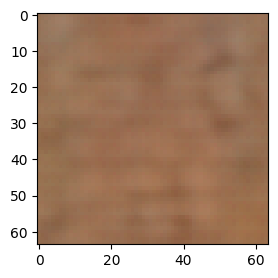

In [22]:
# скорее всего латентное пространство слишком большой размерности и поэтому получается каша
plt.figure(figsize=(3, 3))
plt.imshow(to_imshow(output)[3])
plt.show()

## 1.5 Time to make fun! (3 балла)

Давайте научимся пририсовывать людям улыбки =)

<img src="https://i.imgur.com/tOE9rDK.png" alt="linear" width="700" height="400">

План такой:

1. Нужно выделить "вектор улыбки": для этого нужно из выборки изображений найти несколько (~15) людей с улыбками и столько же без.

Найти людей с улыбками вам поможет файл с описанием датасета, скачанный вместе с датасетом. В нем указаны имена картинок и присутствубщие атрибуты (улыбки, очки...)

2. Вычислить латентный вектор для всех улыбающихся людей (прогнать их через encoder) и то же для всех грустненьких

3. Вычислить, собственно, вектор улыбки -- посчитать разность между средним латентным вектором улыбающихся людей и средним латентным вектором грустных людей

4. А теперь приделаем улыбку грустному человеку: добавим полученный в пункте 3 вектор к латентному вектору грустного человека и прогоним полученный вектор через decoder. Получим того же человека, но уже не грустненького!

In [23]:
# заново загружаем датафрейм, потому что в изначальном не были указаны имена людей
people = pd.read_csv('lfw_attributes.txt', sep='\t', header=1)

In [24]:
# для большей точности вручную выбраем картинки, где один и тот же человек с улыбкой и без
smiling_indexes = [1987, 185, 405, 1333, 2573, 2816, 3722, 3843, 4623, 4810, 5046, 5071, 5448, 5497, 5619, 6220, 6468, 6842]
unsmiling_indexes = [1986, 184, 404, 1332, 2574, 2815, 3721, 3844, 4622, 4809, 5047, 5072, 5447, 5496, 5620, 6221, 6467, 6843]

In [25]:
# достаем необходимые образцы данных из data
smiling_data = data[smiling_indexes]
unsmiling_data = data[unsmiling_indexes]

In [26]:
# приводим к тензорам и меняем порядок осей
smiling_data = torch.Tensor(smiling_data.swapaxes(1,3).swapaxes(2,3))
unsmiling_data = torch.Tensor(unsmiling_data.swapaxes(1,3).swapaxes(2,3))

In [27]:
# получаем латентные представления улыбающихся и неулбающихся людей
autoencoder.eval()

with torch.no_grad():
  _, latent_smiling = autoencoder(smiling_data.cuda())
  _, latent_unsmiling = autoencoder(unsmiling_data.cuda())

In [28]:
# получаем "вектор улыбки"
smile_vector = latent_smiling.mean(dim = 0) - latent_unsmiling.mean(dim=0)

In [29]:
# создаем функцию для удобного заставляния людей улыбаться
def make_smile(autoencoder, data, smile_vector=smile_vector):
  autoencoder.eval()
  with torch.no_grad():

    latent_space = autoencoder.encoder(data.cuda())
    latent_space += smile_vector
    reconstructed = autoencoder.decoder(latent_space).view(-1, 3, 64, 64)
    return reconstructed

In [30]:
generated_data = make_smile(autoencoder, unsmiling_data.cuda(), smile_vector.cuda())

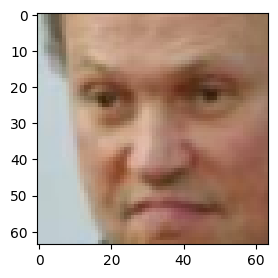

In [31]:
plt.figure(figsize=(3, 3))
plt.imshow(to_imshow(unsmiling_data)[3])
plt.show()

УЛЫБОЧКУ!

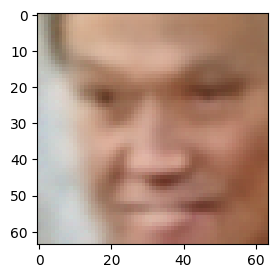

In [32]:
plt.figure(figsize=(3, 3))
plt.imshow(to_imshow(generated_data)[3])
plt.show()

Вуаля! Вы восхитительны!

Теперь вы можете пририсовывать людям не только улыбки, но и много чего другого -- закрывать/открывать глаза, пририсовывать очки... в общем, все, на что хватит фантазии и на что есть атрибуты в `all_attrs`:)

# Часть 2: Variational Autoencoder (10 баллов)

Займемся обучением вариационных автоэнкодеров — проапгрейженной версии AE. Обучать будем на датасете MNIST, содержащем написанные от руки цифры от 0 до 9

In [33]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

## 2.1 Архитектура модели и обучение (2 балла)

Реализуем VAE. Архитектуру (conv, fully-connected, ReLu, etc) можете выбирать сами. Рекомендуем пользоваться более сложными моделями, чем та, что была на семинаре:) Экспериментируйте!

In [34]:
dim_features = 7
class VAE(nn.Module):
    def __init__(self):
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста",
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(10),
            nn.LeakyReLU(),

            nn.Conv2d(10, 20, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(20),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2) ,#batch_size x 20 x 14 x 14

            nn.Conv2d(20, 40, kernel_size= 3, padding = 1),
            nn.BatchNorm2d(40),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2), # batch_size x 40 x 7 x 7

            nn.Flatten(),

            nn.Linear(40 * 7 * 7, dim_features * 2)
            )
        self.decoder = nn.Sequential(
            nn.Linear(dim_features, 40 * 7 * 7),
            nn.Unflatten(1, (40, 7, 7)), # 7
            nn.Upsample(scale_factor=2), # 7 -> 14
            nn.BatchNorm2d(40),
            nn.LeakyReLU(),

            nn.ConvTranspose2d(40, 20, kernel_size = 3, stride = 1, padding = 1), # 14 -> 14
            nn.BatchNorm2d(20),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(20, 1, kernel_size= 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )


    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logvar>
        x = self.encoder(x).view(-1, 2, dim_features)
        mu = x[:, 0, :]
        logvar = x[:, 1, :]
        return mu, logvar

    def gaussian_sampler(self, mu, logvar):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            z = mu + (eps * std)
            return z
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu.
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu

    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logvar = self.encode(x)
        z = self.gaussian_sampler(mu, logvar)

        # decoding
        reconstruction = self.decode(z)
        return mu, logvar, reconstruction

Определим лосс и его компоненты для VAE:

Надеюсь, вы уже прочитали материал в towardsdatascience (или еще где-то) про VAE и знаете, что лосс у VAE состоит из двух частей: KL и log-likelihood.

Общий лосс будет выглядеть так:

$$\mathcal{L} = -D_{KL}(q_{\phi}(z|x)||p(z)) + \log p_{\theta}(x|z)$$

Формула для KL-дивергенции:

$$D_{KL} = -\frac{1}{2}\sum_{i=1}^{dimZ}(1+log(\sigma_i^2)-\mu_i^2-\sigma_i^2)$$

В качестве log-likelihood возьмем привычную нам кросс-энтропию.

In [35]:
def KL_divergence(mu, logsigma):
    """
    часть функции потерь, которая отвечает за "близость" латентных представлений разных людей
    """
    loss = - 0.5 * torch.sum(1 + logsigma - mu.pow(2) - torch.exp(logsigma))
    return loss

def log_likelihood(x, reconstruction):
    """
    часть функции потерь, которая отвечает за качество реконструкции (как mse в обычном autoencoder)
    """
    loss = nn.BCELoss(reduction = 'sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [36]:
def train(model, loss_fn, optimizer, scheduler, data_tr, data_val, n_epochs = 20):
  losses = []


  for epoch in range(n_epochs):
      model.train()
      current_epoch_loss = 0
      print('')

      for X_batch, _ in data_tr:
        optimizer.zero_grad()

        X_batch = X_batch.to(DEVICE)
        mu_train, logvar_train, reconstruction = model(X_batch)
        loss = loss_fn(X_batch, mu_train, logvar_train, reconstruction)
        loss.backward()

        optimizer.step()
        current_epoch_loss += loss.cpu().item()

      avg_loss = current_epoch_loss/len(data_tr)
      print('Epoch: {}. Loss: {}'.format(epoch+1,avg_loss))
      losses.append(avg_loss)
      scheduler.step()
  return losses

И обучим модель:

In [37]:
vae = VAE().to(DEVICE)

optimizer  = optim.Adam(vae.parameters())

scheduler = optim.lr_scheduler.StepLR(optimizer, 10)

loss = loss_vae

torch.cuda.empty_cache()
losses = train(vae, loss_fn=loss, optimizer = optimizer, scheduler = scheduler, data_tr = train_loader, data_val = None, n_epochs = 20)


Epoch: 1. Loss: 4885.417300260417

Epoch: 2. Loss: 3937.352505859375

Epoch: 3. Loss: 3827.2100096354166

Epoch: 4. Loss: 3768.9780985677085

Epoch: 5. Loss: 3729.8142484375

Epoch: 6. Loss: 3704.2559671875

Epoch: 7. Loss: 3680.550104427083

Epoch: 8. Loss: 3662.795991015625

Epoch: 9. Loss: 3648.0840473958333

Epoch: 10. Loss: 3634.6986608072916

Epoch: 11. Loss: 3583.453580859375

Epoch: 12. Loss: 3575.548916927083

Epoch: 13. Loss: 3572.4394463541666

Epoch: 14. Loss: 3571.1520658854165

Epoch: 15. Loss: 3569.157958984375

Epoch: 16. Loss: 3566.5671796875

Epoch: 17. Loss: 3564.5806036458334

Epoch: 18. Loss: 3564.156468880208

Epoch: 19. Loss: 3561.654388671875

Epoch: 20. Loss: 3559.90254375


Давайте посмотрим, как наш тренированный VAE кодирует и восстанавливает картинки:

In [38]:
tempbatch = next(iter(test_loader))[0]

In [39]:
vae.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Flatten(start_dim=1, end_dim=-1)
    (12): Linear(in_features=1960, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=7, out_features=1960, bias=

In [40]:
with torch.no_grad():
  _mu, _logvar, temp_generated = vae(tempbatch.cuda())

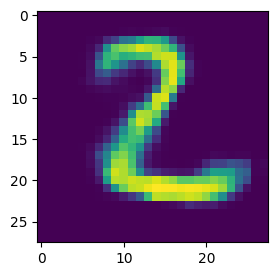

In [41]:
# берем 2 картинку из восстановленного батча
plt.figure(figsize=(3, 3))
plt.imshow(temp_generated.cpu().detach().squeeze()[1])
plt.show()

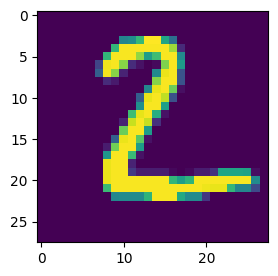

In [42]:
plt.figure(figsize=(3, 3))
plt.imshow(tempbatch.cpu().detach().squeeze()[1])
plt.show()

Давайте попробуем проделать для VAE то же, что и с обычным автоэнкодером -- подсунуть decoder'у из VAE случайные векторы из нормального распределения и посмотреть, какие картинки получаются:

In [43]:
# вспомните про замечание из этого же пункта обычного AE про распределение латентных переменных
# делаем батч из 10 случайных латентных векторов
z = np.array([np.random.normal(0, 1, dim_features) for i in range(10)])
with torch.no_grad():
  # генерируем данные из латентных векторов
  temp_generated = vae.decode(torch.Tensor(z).cuda())

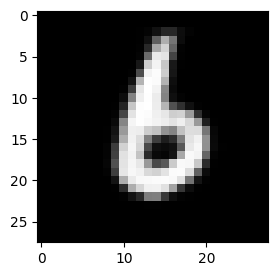

In [44]:
# вывод результата
plt.figure(figsize=(3, 3))
plt.imshow(temp_generated.cpu().detach().squeeze()[2], cmap='gray')
plt.show()

## 2.2. Latent Representation (2 балла)

Давайте посмотрим, как латентные векторы картинок лиц выглядят в пространстве.
Ваша задача -- изобразить латентные векторы картинок точками в двумерном просторанстве.

Это позволит оценить, насколько плотно распределены латентные векторы изображений цифр в пространстве.

Плюс давайте сделаем такую вещь: покрасим точки, которые соответствуют картинкам каждой цифры, в свой отдельный цвет

Подсказка: красить -- это просто =) У plt.scatter есть параметр c (color), см. в документации.


Итак, план:
1. Получить латентные представления картинок тестового датасета
2. С помощтю `TSNE` (есть в `sklearn`) сжать эти представления до размерности 2 (чтобы можно было их визуализировать точками в пространстве)
3. Визуализировать полученные двумерные представления с помощью `matplotlib.scatter`, покрасить разными цветами точки, соответствующие картинкам разных цифр.

In [45]:
# код получения латентных представлений, применения TSNE и визуализаци>
vae.eval()
latent_representation = []
i = 0
with torch.no_grad():
  for test_batch, _ in test_loader:
    mu, logvar = vae.encode(test_batch.cuda())
    z = vae.gaussian_sampler(mu, logvar)
    latent_representation.append(z.cpu().detach().numpy())
latent_representation = np.vstack(latent_representation)

In [46]:
tsne = TSNE()
pred = tsne.fit_transform(latent_representation)

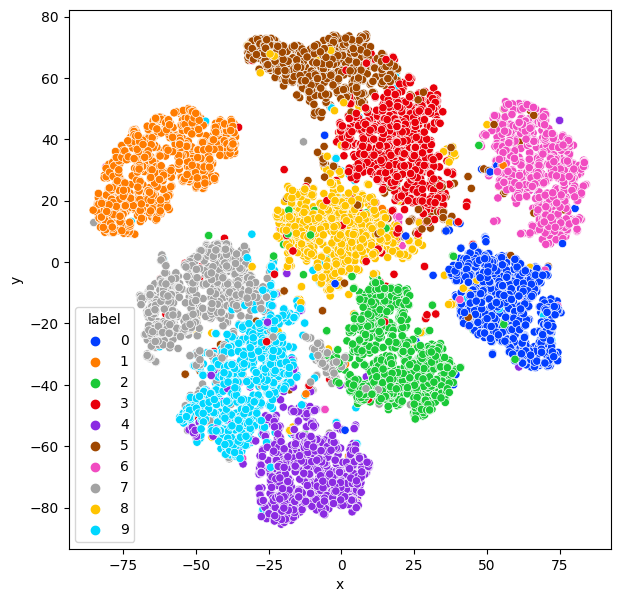

In [47]:
import seaborn as sns

# для pred - это объект типа numpy.ndarray
df_pred = pd.DataFrame({'x': pred[:, 0], 'y': pred[:, 1], 'label': test_dataset.targets})

# вывод результата
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_pred, x='x', y='y', hue='label', palette=sns.color_palette('bright', 10))
plt.show()

Что вы думаете о виде латентного представления?

__Congrats v2.0!__

## 2.3. Conditional VAE (6 баллов)


Мы уже научились обучать обычный AE на датасете картинок и получать новые картинки, используя генерацию шума и декодер.
Давайте теперь допустим, что мы обучили AE на датасете MNIST и теперь хотим генерировать новые картинки с числами с помощью декодера (как выше мы генерили рандомные лица).
И вот нам понадобилось сгенерировать цифру 8, и мы подставляем разные варианты шума, но восьмерка никак не генерится:(

Хотелось бы добавить к нашему AE функцию "выдай мне рандомное число из вот этого вот класса", где классов десять (цифры от 0 до 9 образуют десять классов).  Conditional AE — так называется вид автоэнкодера, который предоставляет такую возможность. Ну, название "conditional" уже говорит само за себя.

И в этой части задания мы научимся такие обучать.

### Архитектура

На картинке ниже представлена архитектура простого Conditional VAE.

По сути, единственное отличие от обычного -- это то, что мы вместе с картинкой в первом слое энкодера и декодера передаем еще информацию о классе картинки.

То есть, в первый (входной) слой энкодера подается конкатенация картинки и информации о классе (например, вектора из девяти нулей и одной единицы). В первый слой декодера подается конкатенация латентного вектора и информации о классе.


![alt text](https://sun9-63.userapi.com/impg/Mh1akf7mfpNoprrSWsPOouazSmTPMazYYF49Tw/djoHNw_9KVA.jpg?size=1175x642&quality=96&sign=e88baec5f9bb91c8443fba31dcf0a4df&type=album)

![alt text](https://sun9-73.userapi.com/impg/UDuloLNKhzTBYAKewgxke5-YPsAKyGOqA-qCRg/MnyCavJidxM.jpg?size=1229x651&quality=96&sign=f2d21bfacc1c5755b76868dc4cfef39c&type=album)



На всякий случай: это VAE, то есть, latent у него все еще состоит из mu и sigma

Таким образом, при генерации новой рандомной картинки мы должны будем передать декодеру сконкатенированные латентный вектор и класс картинки.

P.S. Также можно передавать класс картинки не только в первый слой, но и в каждый слой сети. То есть на каждом слое конкатенировать выход из предыдущего слоя и информацию о классе.

In [48]:
dim_features = 7

class CVAE(nn.Module):
  def __init__(self):
    super().__init__()

    self.encoder = nn.Sequential(
        nn.Linear(28*28 + 10, 300),
        nn.BatchNorm1d(300),
        nn.LeakyReLU(),

        nn.Linear(300, 150),
        nn.BatchNorm1d(150),
        nn.LeakyReLU(),

        nn.Linear(150, 50),
        nn.BatchNorm1d(50),
        nn.LeakyReLU(),

        nn.Linear(50, dim_features * 2)
    )
    self.decoder = nn.Sequential(
        nn.Linear(dim_features + 10, 50),
        nn.BatchNorm1d(50),
        nn.LeakyReLU(),

        nn.Linear(50, 150),
        nn.BatchNorm1d(150),
        nn.LeakyReLU(),

        nn.Linear(150, 300),
        nn.BatchNorm1d(300),
        nn.LeakyReLU(),

        nn.Linear(300, 28*28),
        nn.Unflatten(1, (1, 28,28)),

        nn.Sigmoid()
    )
  def encode(self, x, class_num):
    a = torch.flatten(x, start_dim = 1)

    a = torch.cat([a, class_num], dim = 1)
    z = self.encoder(a).view(-1, 2, dim_features)

    mu = z[:, 0, :]
    logsigma = z[:, 1, :]

    return mu, logsigma, class_num

  def gaussian_sampler(self, mu, logsigma):
    if self.training:
      std = torch.exp(0.5 * logsigma)
      eps = torch.randn_like(std)
      z = mu + (std*eps)
      return z
    else:
      return mu
  def decode(self, z, class_num):
    reconstruction = self.decoder(torch.cat([z, class_num], dim = 1))
    return reconstruction

  def forward(self, x, class_num):
    mu, logsigma, class_num = self.encode(x, class_num)
    z = self.gaussian_sampler(mu, logsigma)

    reconstruction = self.decode(z, class_num)

    return mu, logsigma, reconstruction

In [49]:
def train(model, loss_fn, optimizer, scheduler, data_tr, data_val = None, n_epochs = 20):
  losses = []

  for epoch in tqdm_notebook(range(n_epochs)):
    model.train()
    current_epoch_loss = 0
    print('')

    for x_batch, class_num in data_tr:
      optimizer.zero_grad()

      x_batch = x_batch.to(DEVICE)
      class_num = F.one_hot(class_num, 10)
      class_num  = class_num.to(DEVICE)

      mu_train, logsigma_train, reconstruction = model(x_batch, class_num)


      loss = loss_fn(x_batch, mu_train, logsigma_train, reconstruction)

      loss.backward()

      optimizer.step()

      current_epoch_loss += loss.cpu().item()

    avg_loss = current_epoch_loss/ len(data_tr)
    print('Epoch: {}. Loss: {}'.format(epoch+1, avg_loss))
    losses.append(avg_loss)
    scheduler.step()
  return losses

### Sampling


Тут мы будем сэмплировать из CVAE. Это прикольнее, чем сэмплировать из простого AE/VAE: тут можно взять один и тот же латентный вектор и попросить CVAE восстановить из него картинки разных классов!
Для MNIST вы можете попросить CVAE восстановить из одного латентного вектора, например, картинки цифры 5 и 7.

In [50]:
# <тут нужно научиться сэмплировать из декодера цифры определенного класса>
# обучим CVAE
cvae = CVAE().to(DEVICE)
optimizer = optim.Adam(cvae.parameters())

scheduler = optim.lr_scheduler.StepLR(optimizer, 10)
loss = loss_vae

torch.cuda.empty_cache()
losses = train(cvae, loss_fn=loss, optimizer = optimizer, scheduler = scheduler, data_tr = train_loader, data_val = None, n_epochs = 20)

<ipython-input-49-12f7a8056129>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm_notebook(range(n_epochs)):


  0%|          | 0/20 [00:00<?, ?it/s]


Epoch: 1. Loss: 4468.748424739583

Epoch: 2. Loss: 3932.6370360677083

Epoch: 3. Loss: 3823.896810807292

Epoch: 4. Loss: 3761.89381953125

Epoch: 5. Loss: 3719.1752541666665

Epoch: 6. Loss: 3685.3130069010417

Epoch: 7. Loss: 3660.0593838541668

Epoch: 8. Loss: 3629.1893733072916

Epoch: 9. Loss: 3612.260501041667

Epoch: 10. Loss: 3596.1742263020833

Epoch: 11. Loss: 3517.0965209635415

Epoch: 12. Loss: 3505.0529397135415

Epoch: 13. Loss: 3495.23480546875

Epoch: 14. Loss: 3495.338073307292

Epoch: 15. Loss: 3492.23419609375

Epoch: 16. Loss: 3489.2822375

Epoch: 17. Loss: 3485.9574186197915

Epoch: 18. Loss: 3484.014210026042

Epoch: 19. Loss: 3479.501729166667

Epoch: 20. Loss: 3475.0969766927083


In [51]:
cvae.eval()

CVAE(
  (encoder): Sequential(
    (0): Linear(in_features=794, out_features=300, bias=True)
    (1): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=300, out_features=150, bias=True)
    (4): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=150, out_features=50, bias=True)
    (7): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=50, out_features=14, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=17, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=50, out_features=150, bias=True)
    (4): BatchNorm1d(150, eps=1e-05, momentum=0.1, affin

In [52]:
indexes_for_onehot = torch.IntTensor([0, 1,2,3,4,5,6,7,8,9]).to(torch.int64)

with torch.no_grad():
  onehot_matrix = F.one_hot(indexes_for_onehot, 10)

  latent_vector = np.array([np.random.normal(0, 1, dim_features) for i in range(10)])
  temp_generated  = cvae.decode(torch.Tensor(latent_vector).cuda(), onehot_matrix.cuda()).cpu().detach().squeeze()

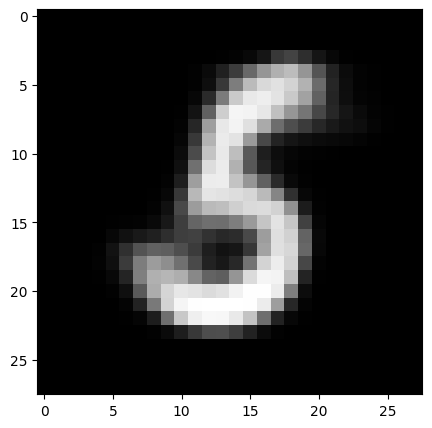

In [53]:
plt.figure(figsize=(5, 5))
plt.imshow(temp_generated[5], cmap='gray')
plt.show()

Splendid! Вы великолепны!


### Latent Representations

Давайте посмотрим, как выглядит латентное пространство картинок в CVAE и сравним с картинкой для VAE =)

Опять же, нужно покрасить точки в разные цвета в зависимости от класса.

In [54]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>

cvae.eval()
latent_representation = []
i = 0
with torch.no_grad():
  for test_batch, class_num in test_loader:
    class_num = F.one_hot(class_num, 10)

    mu, logvar, class_num_1 = cvae.encode(test_batch.cuda(), class_num.cuda())
    z = cvae.gaussian_sampler(mu, logvar)
    latent_representation.append(z.cpu().detach().numpy())
latent_representation = np.vstack(latent_representation)

In [55]:
tsne = TSNE()
pred = tsne.fit_transform(latent_representation)

In [56]:
# для pred - это объекта типа numpy.ndarray
df_dred = pd.DataFrame({'x': pred[:, 0], 'y': pred[:, 1], 'label': test_dataset.targets})

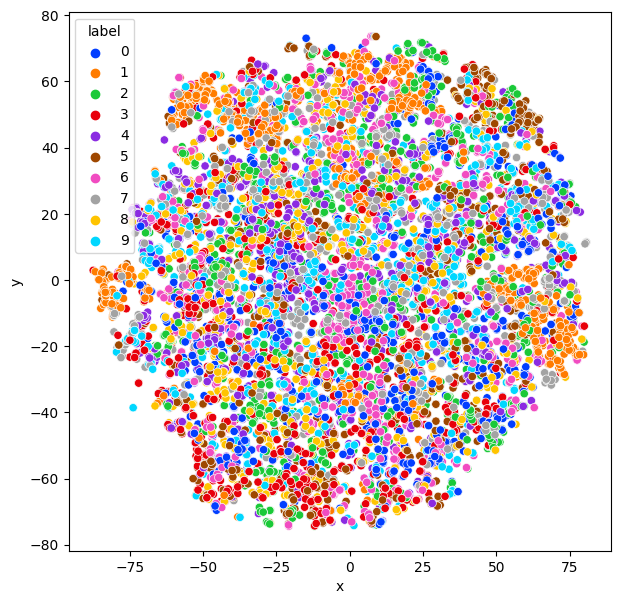

In [57]:
# вывод результата
plt.figure(figsize=(7, 7))
sns.scatterplot(data=df_dred, x='x', y='y', hue='label', palette=sns.color_palette('bright', 10))
plt.show()

Что вы думаете насчет этой картинки? Отличается от картинки для VAE?

# BONUS 1: Denoising

## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

У автоэнкодеров, кроме сжатия и генерации изображений, есть другие практические применения. Про одно из них эта бонусная часть задания.

Автоэнкодеры могут быть использованы для избавления от шума на фотографиях (denoising). Для этого их нужно обучить специальным образом: input картинка будет зашумленной, а выдавать автоэнкодер должен будет картинку без шума.
То есть, loss-функция AE останется той же (MSE между реальной картинкой и выданной), а на вход автоэнкодеру будет подаваться зашумленная картинка.

<a href="https://ibb.co/YbRJ1nZ"><img src="https://i.ibb.co/0QD164t/Screen-Shot-2020-06-04-at-4-49-50-PM.png" alt="Screen-Shot-2020-06-04-at-4-49-50-PM" border="0"></a>

Для этого нужно взять ваш любимый датасет (датасет лиц из первой части этого задания или любой другой) и сделать копию этого датасета с шумом.

В питоне шум можно добавить так:

In [58]:
# noise_factor = 0.5
# X_noisy = X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X.shape)

In [59]:
# <тут ваш код обучения автоэнкодера на зашумленных картинках. Не забудтье разбить на train/test!>

In [60]:
# <тут проверка, как AE убирает щум с тестовых картинок. Надеюсь, все получилось =)>

# BONUS 2: Image Retrieval

1.   Новый пункт
2.   Новый пункт



## Внимание! За бонусы доп. баллы не ставятся, но вы можете сделать их для себя.

Давайте представим, что весь наш тренировочный датасет -- это большая база данных людей. И вот мы получили картинку лица какого-то человека с уличной камеры наблюдения (у нас это картинка из тестового датасета) и хотим понять, что это за человек. Что нам делать? Правильно -- берем наш VAE, кодируем картинку в латентное представление и ищем среди латентныз представлений лиц нашей базы самые ближайшие!

План:

1. Получаем латентные представления всех лиц тренировочного датасета
2. Обучаем на них LSHForest `(sklearn.neighbors.LSHForest)`, например, с `n_estimators=50`
3. Берем картинку из тестового датасета, с помощью VAE получаем ее латентный вектор
4. Ищем с помощью обученного LSHForest ближайшие из латентных представлений тренировочной базы
5. Находим лица тренировочного датасета, которым соответствуют ближайшие латентные представления, визуализируем!

Немного кода вам в помощь: (feel free to delete everything and write your own)

In [61]:
# codes = <поучите латентные представления картинок из трейна>

In [62]:
# # обучаем LSHForest
# from sklearn.neighbors import LSHForest
# lshf = LSHForest(n_estimators=50).fit(codes)

In [63]:
# def get_similar(image, n_neighbors=5):
#   # функция, которая берет тестовый image и с помощью метода kneighbours у LSHForest ищет ближайшие векторы
#   # прогоняет векторы через декодер и получает картинки ближайших людей

#   code = <получение латентного представления image>

#   (distances,),(idx,) = lshf.kneighbors(code, n_neighbors=n_neighbors)

#   return distances, X_train[idx]

In [64]:
# def show_similar(image):

#   # функция, которая принимает тестовый image, ищет ближайшие к нему и визуализирует результат

#     distances,neighbors = get_similar(image,n_neighbors=11)

#     plt.figure(figsize=[8,6])
#     plt.subplot(3,4,1)
#     plt.imshow(image.cpu().numpy().transpose([1,2,0]))
#     plt.title("Original image")

#     for i in range(11):
#         plt.subplot(3,4,i+2)
#         plt.imshow(neighbors[i].cpu().numpy().transpose([1,2,0]))
#         plt.title("Dist=%.3f"%distances[i])
#     plt.show()

In [65]:
# <тут выведите самые похожие лица к какому-нибудь лицу из тестовой части датасета>

In [66]:
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  0% |  8% |


In [67]:
torch.cuda.empty_cache()
autoencoder.cpu()
del scheduler
del optimizer
del autoencoder
gc.collect()
torch.cuda.empty_cache()
gpu_usage()

| ID | GPU | MEM |
------------------
|  0 |  1% |  8% |
